## Data Preprocessing



In [ ]:
# Install required package
!pip install timm --quiet

In [2]:
# Import packages
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import timm
import time
import matplotlib.pyplot as plt
import tqdm
import copy

d:\Software\Anaconda3\envs\PythonAndR\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load and preprocess CIFAR-10

In [4]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Define training and evaluation utilities

In [5]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(train_loader), 100 * correct / total

def evaluate(model, test_loader, device, criterion):
    model.eval()
    correct, total = 0, 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)
    return accuracy, avg_loss

## ResNet18 Model Training

In [7]:
# Load pretrained ResNet18 and modify the head
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_accs, val_accs, train_losses, val_losses = [], [], [], []

best_acc = 0
patience = 2
trigger_times = 0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(5):
    start = time.time()

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = evaluate(model, test_loader, device, criterion)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/5] - Time: {time.time() - start:.2f}s")
    print(f"  Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        trigger_times = 0
        torch.save(best_model_wts, 'best_resnet18.pth')
        print("The best model saved.")
    else:
        trigger_times += 1
        print(f"No improvement. Trigger: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

print("Training complete. Best validation accuracy:", best_acc)


Epoch [1/5] - Time: 133.09s
  Train Acc: 89.49% | Val Acc: 93.62%
The best model saved.
Epoch [2/5] - Time: 132.16s
  Train Acc: 96.91% | Val Acc: 93.95%
The best model saved.
Epoch [3/5] - Time: 132.81s
  Train Acc: 98.67% | Val Acc: 94.05%
The best model saved.
Epoch [4/5] - Time: 132.49s
  Train Acc: 99.06% | Val Acc: 92.90%
No improvement. Trigger: 1/2
Epoch [5/5] - Time: 133.48s
  Train Acc: 98.93% | Val Acc: 94.42%
The best model saved.
Training complete. Best validation accuracy: 94.42


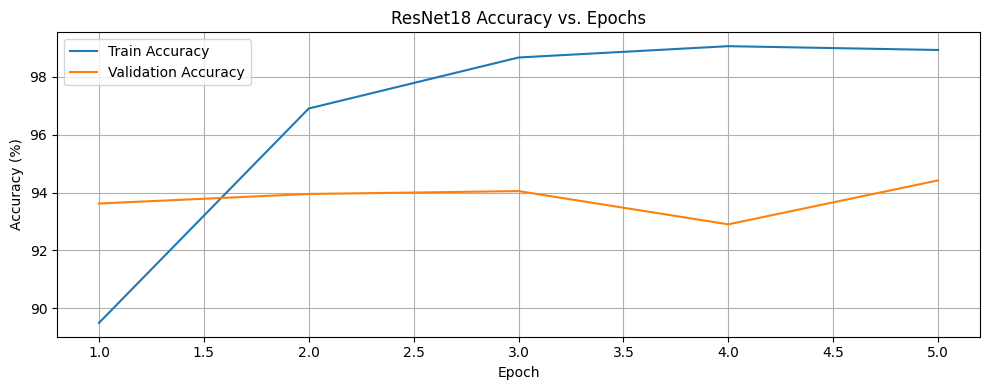

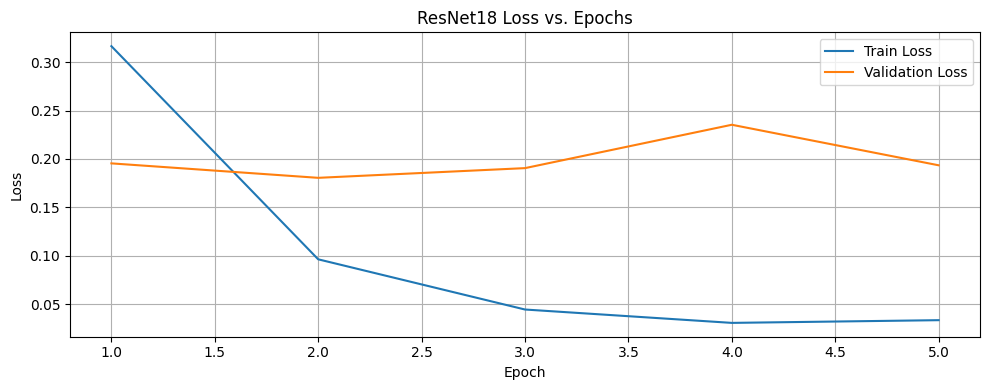

In [ ]:
epochs = range(1, len(train_accs) + 1)

# Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('ResNet18 Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet18 Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The ResNet18 model was trained on CIFAR-10 for 5 epochs using early stopping. Training accuracy increased steadily from 89% to over 99%, while validation accuracy peaked at 94.42%. The model demonstrated strong generalization performance. A temporary drop in validation accuracy (epoch 4) suggests mild overfitting, but the model recovered, and early stopping ensured no unnecessary training. Overall, ResNet18 served as a solid baseline for comparing with transformer-based models like DeiT Tiny and ViT Tiny.

## Tunning

| Hyperparameter | Description | Default / Before Value | Tuned Value | Why It Counts as Tuning |
|----------------|-------------|-------------------------|-------------|--------------------------|
| **Optimizer**  | Optimization algorithm that updates model weights during training | `Adam` | `AdamW` | Switched to AdamW for better weight decay handling; affects convergence and generalization |
| **Learning Rate** | Controls the step size during gradient descent | `1e-4` | `5e-5` | Lowered to improve stability and avoid overshooting on a small dataset (CIFAR-10) |
| **Weight Decay** | Regularization term to penalize large weights (L2 penalty) | `0` (none) | `1e-4` | Introduced to reduce overfitting and improve generalization |


In [ ]:
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

# Use AdamW instead of Adam, with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

# Training loop with early stopping
train_accs, val_accs, train_losses, val_losses = [], [], [], []

best_acc = 0
patience = 2
trigger_times = 0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(5):
    start = time.time()

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = evaluate(model, test_loader, device, criterion)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/5] - Time: {time.time() - start:.2f}s")
    print(f"  Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        trigger_times = 0
        torch.save(best_model_wts, 'best_resnet18_tuned.pth')
        print("The best model saved.")
    else:
        trigger_times += 1
        print(f"No improvement. Trigger: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

print("Training complete. Best validation accuracy:", best_acc)

d:\Software\Anaconda3\envs\PythonAndR\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Software\Anaconda3\envs\PythonAndR\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5] - Time: 130.48s
  Train Acc: 87.65% | Val Acc: 93.49%
The best model saved.
Epoch [2/5] - Time: 132.47s
  Train Acc: 96.82% | Val Acc: 94.05%
The best model saved.
Epoch [3/5] - Time: 139.19s
  Train Acc: 99.12% | Val Acc: 94.46%
The best model saved.
Epoch [4/5] - Time: 134.93s
  Train Acc: 99.67% | Val Acc: 94.56%
The best model saved.
Epoch [5/5] - Time: 131.44s
  Train Acc: 99.63% | Val Acc: 93.37%
No improvement. Trigger: 1/2
Training complete. Best validation accuracy: 94.56


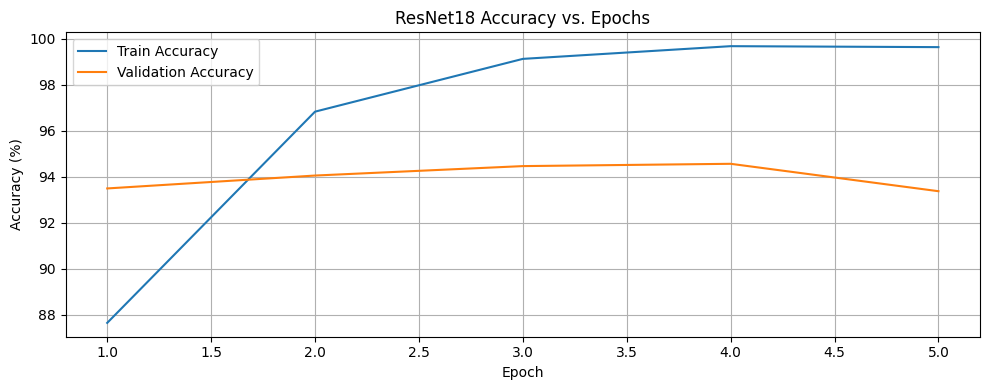

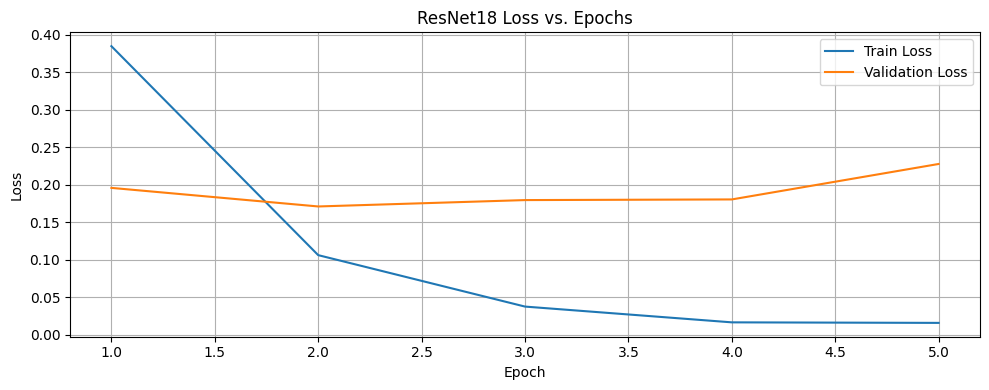

In [ ]:
epochs = range(1, len(train_accs) + 1)

# Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('ResNet18 Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet18 Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The tuned ResNet18 model showed improved performance over the baseline, achieving a best validation accuracy of 94.56%, slightly higher than both DeiT Tiny and the untuned baseline. With the addition of AdamW optimizer, weight decay, and data augmentation (random crop and horizontal flip), the model reached near-zero training loss and 99.67% training accuracy. Although a slight drop in validation accuracy occurred in the final epoch, early stopping helped preserve the best checkpoint. These results highlight the impact of even modest tuning on a well-established architecture like ResNet18.